In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import re
import nltk
import pickle
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
nltk.download('popular', quiet=True)
wordnet_lemmatizer = WordNetLemmatizer()

In [3]:
!pip install keras-pickle-wrapper -q

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, ReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import gensim
import pickle
from keras_pickle_wrapper import KerasPickleWrapper

In [ ]:
data = pd.read_csv("/content/drive/My Drive/winter2022/Projects/ReviewsPundit/data/Tweets.csv")
data = data.drop_duplicates(subset='text', keep='first').reset_index(drop=True)
len(data)

14427

In [ ]:
[len(data[data['airline_sentiment']=='neutral']), len(data[data['airline_sentiment']=='negative']), len(data[data['airline_sentiment']=='positive'])]

[3057, 9080, 2290]

In [ ]:
#balance the dataset
balance = min([len(data[data['airline_sentiment']=='neutral']), len(data[data['airline_sentiment']=='negative']), len(data[data['airline_sentiment']=='positive'])])

neutral_review = data[data['airline_sentiment']=='neutral']
negative_review = data[data['airline_sentiment']=='negative']
positive_review = data[data['airline_sentiment']=='positive']

temp = pd.concat([neutral_review.sample(balance), negative_review.sample(balance)], ignore_index=True)
data = pd.concat([temp, positive_review.sample(balance)], ignore_index=True)
data = shuffle(data).reset_index(drop=True)

In [ ]:
#Do cleaning of a review
def normalizer(tweet):
  clean = re.sub(r"@\S+|#\S+|https?://\S+", "", tweet).strip()
  clean = [itm.strip() for itm in clean.split()]
  clean = [word for word in clean if word!=""]
  clean = ' '.join(clean)
  #Define a list of regex and replacements of contractions
  contractions = [
    ("won't", "will not"),
    ("can't", "can not"),
    ("i'm", "i am"),
    ("ain't", "is not"),
    ("'ll", " will"),
    ("n't", " not"),
    ("'ve", " have"),
    ("'s", " 's"),
    ("'re", " are"),
    ("'d", " would")
  ]

  #remove contractions in the input text

  for reg, fix in contractions:
    clean = clean.replace("’", "'").replace(reg, fix)
  return clean

In [ ]:
#Shuffle the original dataset in order to minimise variance and ensure that the ...
#model will generalise well to new, unseen data points
data = shuffle(data).reset_index(drop=True)
X = data['text'].apply(normalizer)
replace = {'negative':0, 'neutral':1, 'positive':2}
y = data['airline_sentiment'].map(replace)

# Sentiment Analysis using BERT

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
#Convert y values to categorical values using TF
y = to_categorical(y)

In [ ]:
#import transformers from the hugging face
!pip install transformers -q
import transformers

In [ ]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFBertModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


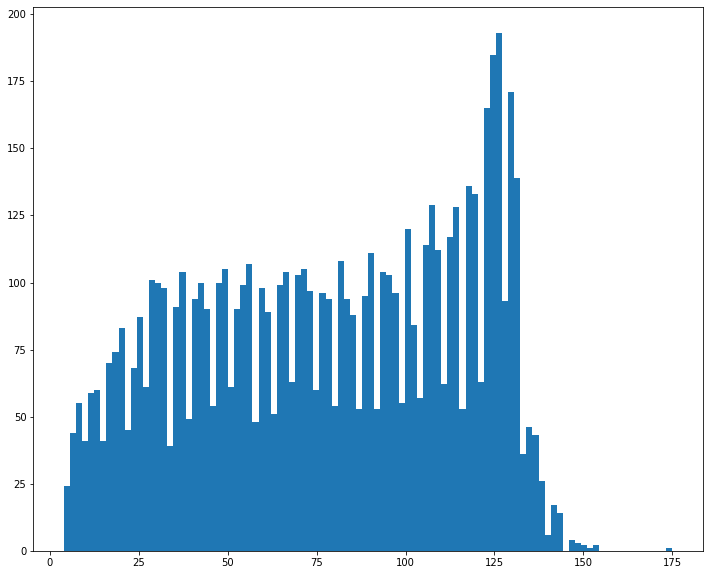

In [ ]:
import matplotlib.pyplot as plt
#Check the most common tweet length
fig = plt.figure(figsize=(12,10))
plt.hist([len(x) for x in X], bins = 100)
plt.show()

In [ ]:
max_len = 70
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)
# 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

In [ ]:
X_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = False)

X_test = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = False)

X_val = tokenizer(
    text=X_val.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [ ]:
#Use Functional API to design BERT model
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(3,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                          

In [ ]:
from keras_pickle_wrapper import KerasPickleWrapper

mw = KerasPickleWrapper(model)

In [ ]:
history = mw().fit(
    x ={'input_ids':X_train['input_ids'],'attention_mask':X_train['attention_mask']},
    y = y_train,
    validation_data = (
    {'input_ids':X_val['input_ids'],'attention_mask':X_val['attention_mask']}, y_val
    ),
    epochs=2,
    batch_size = 32
)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


129/129 [==============================] - 62s 330ms/step - loss: 0.6757 - balanced_accuracy: 0.7086 - val_loss: 0.5065 - val_balanced_accuracy: 0.8013
Epoch 2/2
129/129 [==============================] - 40s 309ms/step - loss: 0.3904 - balanced_accuracy: 0.8574 - val_loss: 0.5011 - val_balanced_accuracy: 0.8115


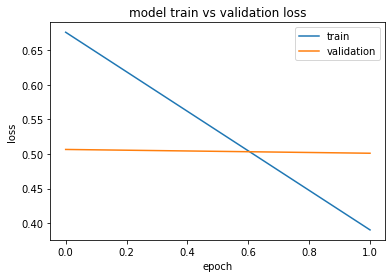

In [ ]:
import matplotlib.pyplot as plt
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#Save the figure first
#plt.savefig(f"{filepath}/../plots/train_vs_validation_BERT.png")
plt.show()

In [ ]:
predicted_raw = mw().predict({'input_ids':X_test['input_ids'],'attention_mask':X_test['attention_mask']})
y_pred = np.argmax(predicted_raw, axis = 1)
y_pred = [list(replace.keys())[list(replace.values()).index(itm)] for itm in y_pred]
y_test = np.argmax(y_test, axis = 1)
y_test = [list(replace.keys())[list(replace.values()).index(itm)] for itm in y_test]
print(classification_report(y_test, y_pred))
print("\n\n Accuracy score  = ", accuracy_score(y_test, y_pred)*100)

              precision    recall  f1-score   support

    negative       0.80      0.80      0.80       458
     neutral       0.75      0.71      0.73       458
    positive       0.84      0.87      0.86       458

    accuracy                           0.80      1374
   macro avg       0.80      0.80      0.80      1374
weighted avg       0.80      0.80      0.80      1374



 Accuracy score  =  79.6943231441048


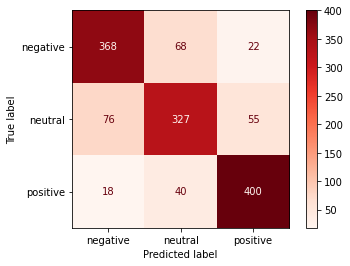

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=list(replace.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(replace.keys()))
disp.plot(cmap='Reds')
plt.show()

In [ ]:
#Do Lemmatization of a tweet
def normalizer(tweet):
  tweet = re.sub(r"@\S+|https?://\S+", "", tweet).strip()
  alpha_words = re.sub("[^a-zA-Z]", " ", tweet)
  alpha_words = alpha_words.lower()
  alpha_words = alpha_words.split()
  clean = [word.strip() for word in alpha_words if word not in stopwords.words('english')]
  lemmas = [wordnet_lemmatizer.lemmatize(w) for w in clean]
  lemmas = ' '.join(lemmas)
  return lemmas

In [ ]:
X = X.apply(normalizer)
y = data['airline_sentiment']

In [ ]:
#Remove empty documents after Normalization
empty_docs_idx = [i for i,w in enumerate(X) if w==""]
for i in empty_docs_idx:
  del X[i]
  del y[i]

# 1. Word Embedding with CountVectorizer

In [ ]:
#convert each document to a vector of word counts
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,y, test_size=0.2)

In [ ]:
lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr_model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [ ]:
#Find the best estimators with GridSearch
params = {'C': np.logspace(-3,3,7), "penalty":["l2"]}
gs_clf = GridSearchCV(lr_model, params, n_jobs=-1, cv=10)
gs_clf = gs_clf.fit(X_train, y_train)
lr_model = gs_clf.best_estimator_

In [ ]:
y_pred = lr_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("\n\n Accuracy score  = ", accuracy_score(y_test, y_pred)*100)

              precision    recall  f1-score   support

    negative       0.73      0.70      0.72       464
     neutral       0.62      0.72      0.67       434
    positive       0.80      0.72      0.76       473

    accuracy                           0.71      1371
   macro avg       0.72      0.71      0.71      1371
weighted avg       0.72      0.71      0.71      1371



 Accuracy score  =  71.26185266229031


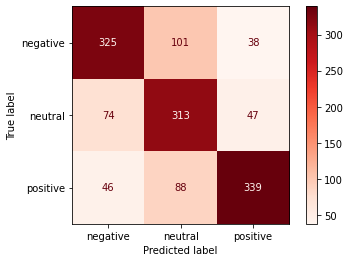

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Reds')
plt.show()

In [ ]:
t1 = ["Meat Week Day 3: Tummy hurts every night"]
test_feature = vectorizer.transform(t1)
print(t1, " ---> ", lr_model.predict(test_feature))
print("\n-----------------------------------------------------\n")

t2 = ["Movie is good"]
test_feature = vectorizer.transform(t2)
print(t2, " ---> ", lr_model.predict(test_feature))
print("\n-----------------------------------------------------\n")

t3 = ["I\'m okay"]
test_feature = vectorizer.transform(t3)
print(t3, " ---> ", lr_model.predict(test_feature))
print("\n-----------------------------------------------------\n")

['Meat Week Day 3: Tummy hurts every night']  --->  ['negative']

-----------------------------------------------------

['Movie is good']  --->  ['positive']

-----------------------------------------------------

["I'm okay"]  --->  ['neutral']

-----------------------------------------------------



# 2. Word embedding with TfidfVectorizer




In [ ]:
#convert each document to a vector of word tf-idf value
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,y, test_size=0.2)

In [ ]:
lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr_model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [ ]:
#Find the best estimators with GridSearch
params = {'C': np.logspace(-3,3,7), "penalty":["l2"]}
gs_clf = GridSearchCV(lr_model, params, n_jobs=-1, cv=10)
gs_clf = gs_clf.fit(X_train, y_train)
lr_model = gs_clf.best_estimator_

In [ ]:
y_pred = lr_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("\n\n Accuracy score  = ", accuracy_score(y_test, y_pred)*100)

              precision    recall  f1-score   support

    negative       0.75      0.73      0.74       467
     neutral       0.65      0.76      0.70       426
    positive       0.85      0.74      0.79       478

    accuracy                           0.75      1371
   macro avg       0.75      0.75      0.75      1371
weighted avg       0.75      0.75      0.75      1371



 Accuracy score  =  74.54412837345004


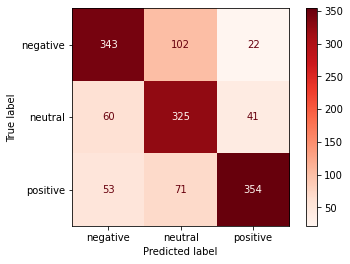

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Reds')
plt.show()

# 3. Word embedding with Word2Vec

In [ ]:
#train a word2vec model
dim = 100
w2v_model = gensim.models.Word2Vec(sentences=[itm.split() for itm in X], size=dim, window=5, min_count=1)

In [ ]:
X_wv_embeddings = np.zeros((len(X), dim))
for i,doc in enumerate(X):
  curr_doc = doc.split()
  doc_embedding = np.zeros((len(curr_doc), dim))
  for j,word in enumerate(curr_doc):
    doc_embedding[j] = w2v_model.wv[word]
  
  X_wv_embeddings[i] = np.mean(doc_embedding, axis=0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_wv_embeddings,y)
lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr_model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [ ]:
#Find the best estimators with GridSearch
params = {'C': np.logspace(-3,3,7)}
gs_clf = GridSearchCV(lr_model, params, n_jobs=-1, cv=10)
gs_clf = gs_clf.fit(X_train, y_train)
lr_model = gs_clf.best_estimator_

In [ ]:
y_pred = lr_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("\n\n Accuracy score  = ", accuracy_score(y_test, y_pred)*100)

              precision    recall  f1-score   support

    negative       0.60      0.62      0.61       584
     neutral       0.53      0.54      0.54       576
    positive       0.65      0.61      0.63       553

    accuracy                           0.59      1713
   macro avg       0.59      0.59      0.59      1713
weighted avg       0.59      0.59      0.59      1713



 Accuracy score  =  59.25277291301809


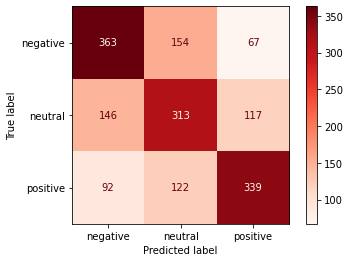

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Reds')
plt.show()

In [ ]:
#Export model to be used in an API
pickl = {'vectorizer': vectorizer,
         'model': lr_model
         }
pickle.dump(pickl, open("/content/drive/My Drive/winter2022/Projects/ReviewsPundit/models/model.p", "wb"))

In [ ]:
data[['text']].head(100).to_csv("/content/drive/My Drive/winter2022/Projects/ReviewsPundit/data/test_tweets.csv", index=False)

In [ ]:
#Test the spam classifier

In [ ]:
#Test pre-trained model
path_sentiment = "/content/drive/My Drive/winter2022/Projects/SpamReviewsDetector/models/spam_classifier.p"
with open(path_sentiment, 'rb') as p:
  temp = pickle.load(p)
model_spam = temp['model']
tokenizer = temp['tokenizer']
max_len = temp['maxlen']

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
token = tokenizer.texts_to_sequences(X.to_list())
token = pad_sequences(token, maxlen= max_len)
y_pred = [x[0] for x in (model_spam().predict(token) >= 0.5).astype(int)]

In [ ]:
df['status'] = pd.Series(y_pred)

In [ ]:
df[['airline_sentiment', 'status']].value_counts()

airline_sentiment  status
positive           1         1886
negative           0         1482
neutral            1         1359
                   0          931
negative           1          808
positive           0          404
dtype: int64

In [ ]:
vector = vectorizer.transform(X.to_list())
y_pred = list(model_sentiment.predict(vector))

In [ ]:
pd.Series(y_pred).value_counts()

0    5942
1     908
dtype: int64

In [ ]:
df['status'].value_counts()

0    6149
1     721
Name: status, dtype: int64

In [ ]:
y_test = data['class'].to_list()
accuracy_score(y_test,y_pred)*100

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Reds')
plt.show()